**Relationship Between Snowpack in the Western US and Climate Indicators (ENSO and PDO)**

This notebook works through a study of the relationship between snowfall in the western continental United States
and the ENSO, PDO, AO, and NAO climate indicators. 

In [ ]:
# First step is to import necessary libraries

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
!pip install shap
import shap

In [ ]:
# Snowfall data was sourced from Copernicus, ERA5 monthly averaged reanalysis data from 1940 to present.
# See README file for DOI.
# The primary variable of interest is "snowfall", provided in units of meters of water equivalent.

# Import snowfall data
ds1 = xr.open_dataset('westus_pt1.nc')
ds2 = xr.open_dataset('westus_pt2.nc')

# Standardize the time columns between both datasets
ds1['valid_time'] = ds1.valid_time.dt.floor('D')
ds2['valid_time'] = ds2.valid_time.dt.floor('D')

# and merge into one xarray dataframe
ds = xr.merge([ds1, ds2])
ds

/tmp/ipykernel_14785/1738585370.py:14: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds1, ds2])
/tmp/ipykernel_14785/1738585370.py:14: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds1, ds2])


<xarray.Dataset> Size: 268MB
Dimensions:     (valid_time: 1030, latitude: 101, longitude: 161)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2025-10-01
  * latitude    (latitude) float64 808B 50.0 49.75 49.5 ... 25.5 25.25 25.0
  * longitude   (longitude) float64 1kB -144.0 -143.8 -143.5 ... -104.2 -104.0
    expver      (valid_time) <U4 16kB '0001' '0001' '0001' ... '0001' '0005'
Data variables:
    tp          (valid_time, latitude, longitude) float32 67MB ...
    sf          (valid_time, latitude, longitude) float32 67MB ...
    t2m         (valid_time, latitude, longitude) float32 67MB ...
    sst         (valid_time, latitude, longitude) float32 67MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-01T02:54 GRIB to CDM+CF via cfgrib-0.9.1...

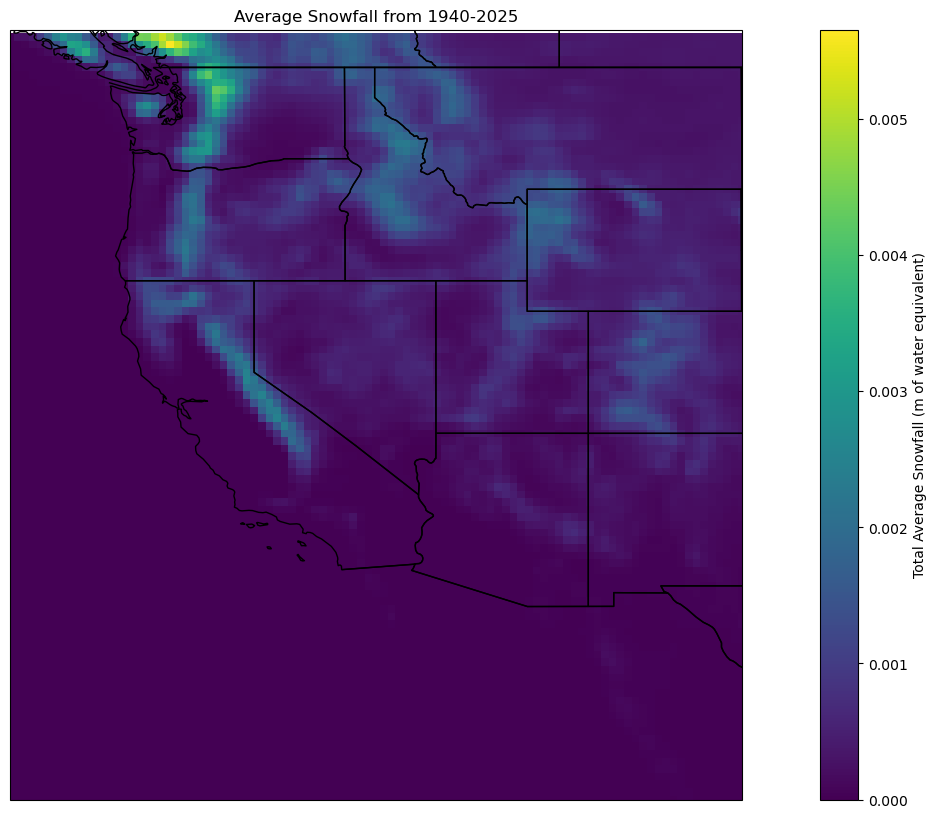

In [ ]:
# But first! I think it will be fun to include a map of snowfall data.
# To map snowfall data, we need to collapse the dataset into 2D by taking the average over time.

ave_snowfall = ds['sf'].mean(dim='valid_time')

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-128, -104, 25, 50])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = ave_snowfall.plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Total Average Snowfall (m of water equivalent)')
ax.set_title('Average Snowfall from 1940-2025')
plt.show()


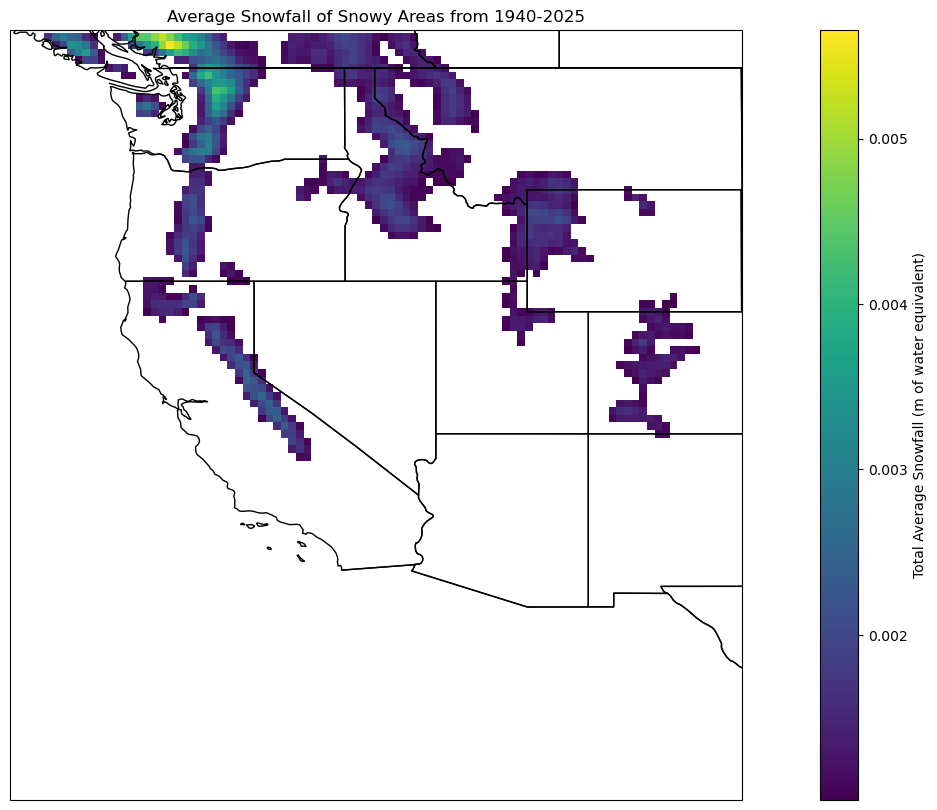

In [ ]:
# I only want to study regions that are "snowy"
# For this assignment, "snowy" is defined as areas where the 1940-2025 average snowfall is >0.001 m.
# We will isolate snowy areas by creating a mask.

snow_mask = ave_snowfall > 0.001
ds_snow = ds.where(snow_mask)

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  
ax.set_extent([-128, -104, 25, 50])   
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES) 
cbar = ds_snow['sf'].mean(dim='valid_time').plot(ax=ax, transform=ccrs.PlateCarree())
cbar.colorbar.set_label('Total Average Snowfall (m of water equivalent)')
ax.set_title('Average Snowfall of Snowy Areas from 1940-2025')
plt.show()

Text(0, 0.5, 'Snowfall (meters of water equivalent)')

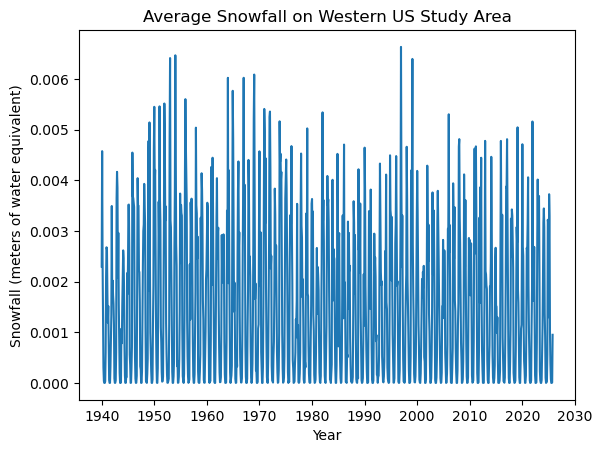

In [ ]:
# Now that we have isolated snowy areas, I am spatially averaging 
# snowfall to see check out trends over time and decompose the time series.

ds_snow_avg = ds_snow.mean(dim=['latitude', 'longitude'])
ds_snow_avg['sf'].plot()
plt.title('Average Snowfall on Western US Study Area')
plt.xlabel('Year')
plt.ylabel('Snowfall (meters of water equivalent)')

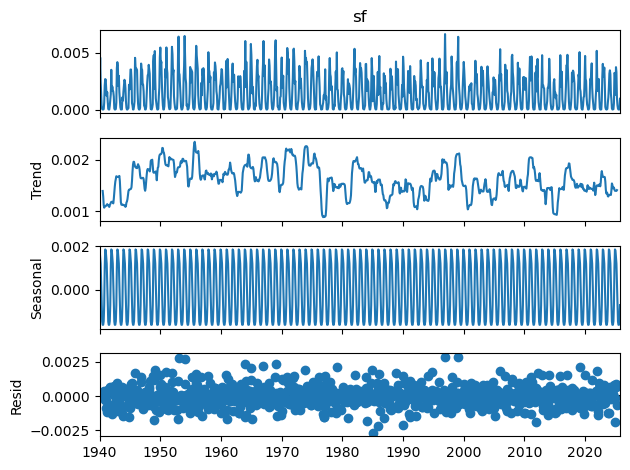

In [ ]:
# Now we decompose!

series = ds_snow_avg['sf'].to_pandas()
series = series.asfreq('MS')
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
plt.show()

In [ ]:
# I want to save each of these new series into a dataframe

decomp = pd.DataFrame({'observed': result.observed,'trend': result.trend,'seasonal': result.seasonal,'resid': result.resid})
decomp = decomp.rename_axis('Date')
decomp = decomp.dropna()

In [ ]:
# Next I am going to import the climate datasets (ENSO, PDO, NAO, AO) that we used in M4N1.

clim = xr.open_dataset('clim.nc')
clim_df = clim.to_dataframe()
clim_df

,ENSO,PDO,NAO,AO
Date,,,,
1951-01-01,1.5,-1.19,0.08,-0.085
1951-02-01,0.9,-1.52,0.70,-0.400
1951-03-01,-0.1,-1.72,-1.02,-1.934
1951-04-01,-0.3,-1.35,-0.22,-0.776
1951-05-01,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...
2025-06-01,0.3,-2.62,0.70,1.134
2025-07-01,0.6,-4.18,0.48,0.500
2025-08-01,0.4,-3.19,0.26,0.036


In [ ]:
# and now I want to merge all data together along the time axis

all = clim_df.join(decomp)
all

,ENSO,PDO,NAO,AO,observed,trend,seasonal,resid
Date,,,,,,,,
1951-01-01,1.5,-1.19,0.08,-0.085,0.005460,0.001889,0.001813,0.001758
1951-02-01,0.9,-1.52,0.70,-0.400,0.003606,0.001891,0.001477,0.000238
1951-03-01,-0.1,-1.72,-1.02,-1.934,0.003197,0.001886,0.001208,0.000103
1951-04-01,-0.3,-1.35,-0.22,-0.776,0.001097,0.001883,0.000258,-0.001044
1951-05-01,-0.7,-1.29,-0.59,-0.863,0.000797,0.001870,-0.000855,-0.000219
...,...,...,...,...,...,...,...,...
2025-06-01,0.3,-2.62,0.70,1.134,NaN,NaN,NaN,NaN
2025-07-01,0.6,-4.18,0.48,0.500,NaN,NaN,NaN,NaN
2025-08-01,0.4,-3.19,0.26,0.036,NaN,NaN,NaN,NaN


In [ ]:
# It is apparent that the climate indices dataset includes more months of data than
# the snowfall dataset. Lets drop those extra rows! In addition, I don't currently need
# the observed/seasonal/resid columns.

all_refined = all.drop(columns=['observed', 'seasonal', 'resid']).dropna()
all_refined

,ENSO,PDO,NAO,AO,trend
Date,,,,,
1951-01-01,1.5,-1.19,0.08,-0.085,0.001889
1951-02-01,0.9,-1.52,0.70,-0.400,0.001891
1951-03-01,-0.1,-1.72,-1.02,-1.934,0.001886
1951-04-01,-0.3,-1.35,-0.22,-0.776,0.001883
1951-05-01,-0.7,-1.29,-0.59,-0.863,0.001870
...,...,...,...,...,...
2024-12-01,1.2,-2.03,1.21,-0.335,0.001396
2025-01-01,0.2,-1.28,-0.52,-0.069,0.001395
2025-02-01,0.5,-1.40,1.60,-0.864,0.001395


In [ ]:
# For the machine learning model, we need to establish the features matrix and target array

X_dsfeatures = all_refined.drop('trend', axis=1)
X_dsfeatures.shape

(892, 4)

In [ ]:
y_dstarget = all_refined['trend']
y_dstarget.shape

(892,)

In [ ]:
# We must split input data into training and testing subsets.

X_train, X_test, y_train, y_test = train_test_split(X_dsfeatures, y_dstarget, random_state=0,
                                  train_size=0.7)

In [ ]:
# train model on training dataset
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
# Predict results from the test dataset
# Then we can use these predicted y values and compare to the actual y values of the test dataset

y_pred = model_linreg.predict(X_test)

In [ ]:
# Test the performance of this model.
# The resulting R2 of 0.17 means that the model explains ~17 percent of the variance in the snowfall 
# trend. This isn't great performance (83% of the variance is still unexplained). There might be 
# other variables involved in predicting snowfall, and we also know meteorological systems have a lot 
# of variability.

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
corr = np.corrcoef(y_test, y_pred)[0, 1]
print('Correlation Coefficient:', corr)
print('Testing Set R² Score:', test_r2)
print('Testing Set Root Mean Squared Error:', test_rmse)


Correlation Coefficient: 0.4371863848167656
Testing Set R² Score: 0.1738677770200069
Testing Set Root Mean Squared Error: 0.0002703300334024248


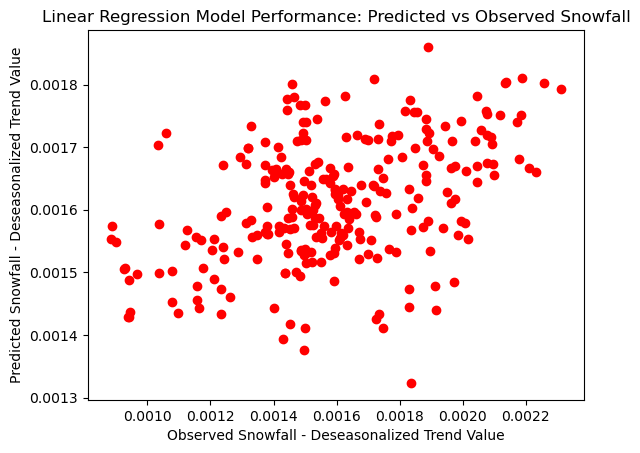

In [ ]:
# Here is a visual representation of the actual y values plotted against predicted y values. 
# A perfect model would be a straight line. Clearly, there is a lot of variability, but we 
# can see a slight correlation. 

plt.scatter(y_test, y_pred, color='red')
plt.xlabel('Observed Snowfall - Deseasonalized Trend Value')
plt.ylabel('Predicted Snowfall - Deseasonalized Trend Value')
plt.title('Linear Regression Model Performance: Predicted vs Observed Snowfall')
plt.show()

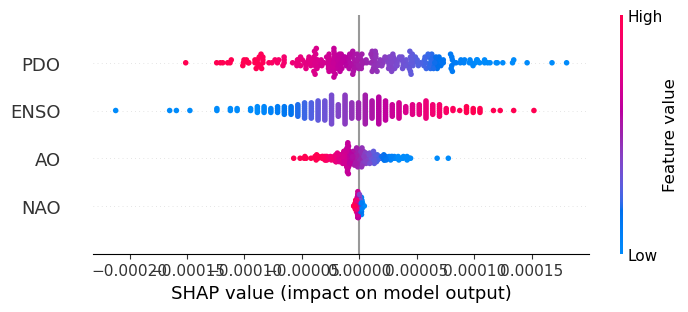

In [ ]:
# I want to utilize the SHAP explainer package to identify which predictor variables
# have the strongest influence on the predicted snowfall value.

# Interpretation of this figure: PDO appears to rank as the feature with strongest importance in predicting
# snowfall. Low PDO values are correlated with higher SHAP value. Inversely, high ENSO values are correlated
# with a lower SHAP value. AO and NAO are not very important features in this model. I also want to note that
# the model performs pretty badly, so these conclusions about feature importance have plenty of caveats in 
# practical application.

shap.initjs()

explainer = shap.Explainer(model_linreg, X_train, feature_names=X_dsfeatures.columns)
shap_values = explainer(X_test) 
shap_values

shap.plots.beeswarm(shap_values)

In [ ]:
# I want to see if we can achieve better model performance with a polynomial regression model.
# The following code block is from from M5N4 to define the olynomialRegression pipeline.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(),
                         LinearRegression(**kwargs))

In [ ]:
# I will also do a grid search to identify the best polynomial regression model.
# Define parameter grid below

param_grid = {'polynomialfeatures__degree': np.arange(0,10),
              'linearregression__fit_intercept': [True, False]}

# and define grid search parameters
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=4, n_jobs=-1)

In [ ]:
# Here we run the grid search on the training dataset, and define the "winner" as a model named "best_polynomial"

grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best cross-validated R²:', grid.best_score_)
best_polynomial = grid.best_estimator_

Best parameters: {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': np.int64(2)}
Best cross-validated R²: 0.11567851976477206


In [ ]:
# Predict results from the test dataset

y_pred_pn = best_polynomial.predict(X_test)

In [ ]:
# Test performance of the polynomial model.
# The R2 of 0.22 is slightly improved compared to the performance of the linear model.

test_r2 = r2_score(y_test, y_pred_pn)
test_mse = mean_squared_error(y_test, y_pred_pn)
test_rmse = np.sqrt(test_mse)
corr = np.corrcoef(y_test, y_pred_pn)[0, 1]
print('Correlation Coefficient:', corr)
print('Testing Set R² Score:', test_r2)
print('Testing Set Root Mean Squared Error:', test_rmse)

Correlation Coefficient: 0.5038830339595075
Testing Set R² Score: 0.22381456473272454
Testing Set Root Mean Squared Error: 0.0002620307510524336


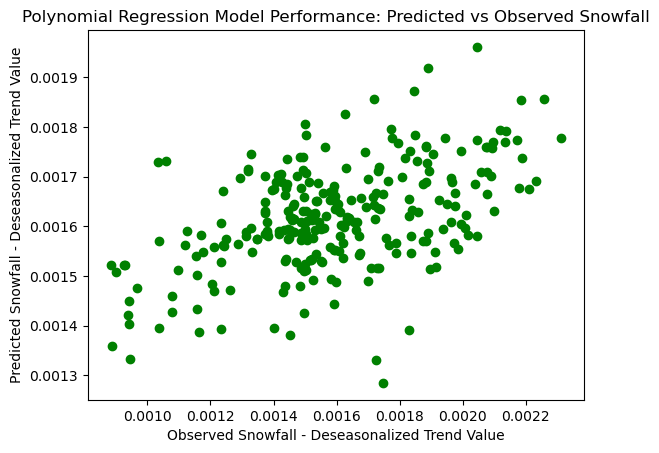

In [ ]:
# Here is a visual representation of the actual y values plotted against y values that were predicated
# using the polynomial regression model. 
 
plt.scatter(y_test, y_pred_pn, color='green')
plt.xlabel('Observed Snowfall - Deseasonalized Trend Value')
plt.ylabel('Predicted Snowfall - Deseasonalized Trend Value')
plt.title('Polynomial Regression Model Performance: Predicted vs Observed Snowfall')
plt.show()

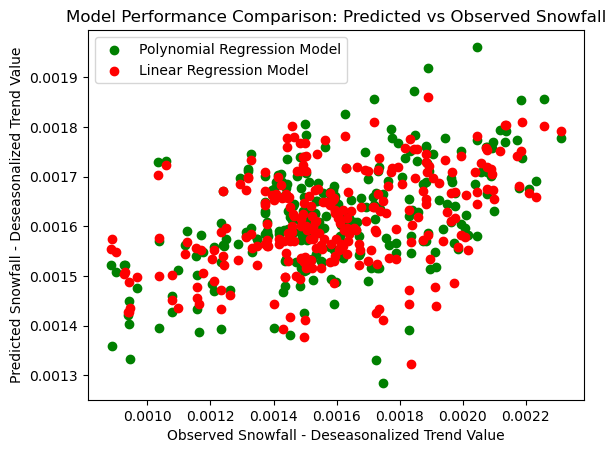

In [ ]:
# Here is a comparison of actual y values (x axis) plotted against y values that were predicated
# using both models. The points in green are predicted from the polynomial model, and should be 
# slightly tighter towards the middle diagonal. 

plt.scatter(y_test, y_pred_pn, color='green', label='Polynomial Regression Model')
plt.scatter(y_test, y_pred, color='red', label='Linear Regression Model')
plt.xlabel("Observed Snowfall - Deseasonalized Trend Value")
plt.ylabel("Predicted Snowfall - Deseasonalized Trend Value")
plt.title("Model Performance Comparison: Predicted vs Observed Snowfall")
plt.legend()
plt.show()

In [ ]:
# The last visualization I would like to prepare is a time series plot of the actual trend values and
# both modeled values. Since the time values were scrambled when splitting into training and testing
# subsets, I need to re-order the date temporally, and I will pop them all into one dataframe.

plot_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred,'y_pred_pn': y_pred_pn})

# Sort by time
plot_df = plot_df.sort_index()

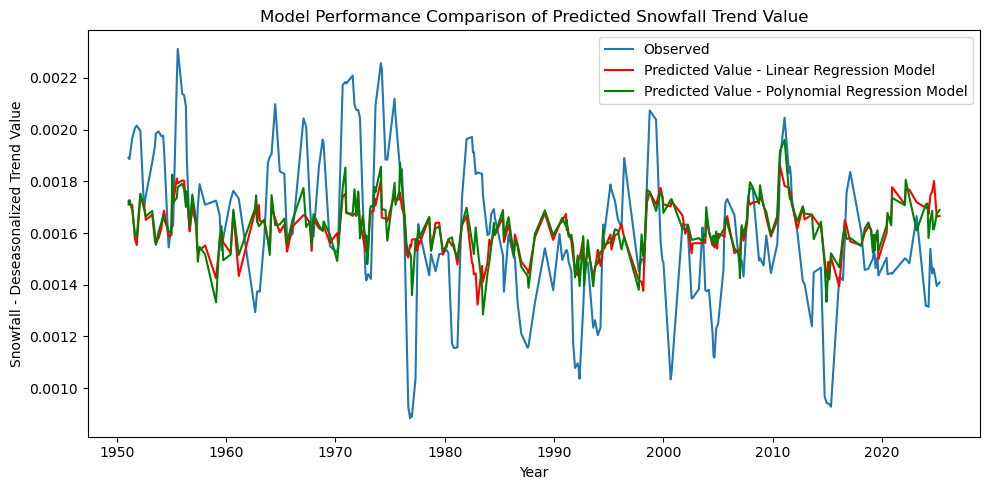

In [ ]:
# And here is the time series plot of observed trend data and the predicted data from the two models.
# My interpretation of this figure is that the observed values have much higher fluctuations in snowfall
# value compared to what was predicted by the models. This suggests that additional input variables may
# be helpful in improving model performance, if I were to continue this exercise.

plt.figure(figsize=(10, 5))
plt.plot(plot_df.index, plot_df['y_test'], label='Observed')
plt.plot(plot_df.index, plot_df['y_pred'], label='Predicted Value - Linear Regression Model', color='red')
plt.plot(plot_df.index, plot_df['y_pred_pn'], label='Predicted Value - Polynomial Regression Model', color='green')
plt.xlabel('Year')
plt.ylabel('Snowfall - Deseasonalized Trend Value')
plt.title('Model Performance Comparison of Predicted Snowfall Trend Value')
plt.legend()
plt.tight_layout()
plt.show()

**Conclusions**

My conclusion of this exercise is that climate indicators do play a small role in explaining some of the annual variability in snowfall in the study area, which is defined as the "snowy" regions of the western US. However, aboout 80 percent of variability in annual snowfall is not explained by the climate indicators, and other variables are at play.

Based on the results of the SHAP analysis, ENSO and PDO are the features that have the most importance in snowfall predictions, whereas AO and NAO are not very correlated with snowfall in the two models created for this project. 

The polynomial regression model performed slightly better than the linear regression model, with an R2 of 0.22 versus 0.17, respectively. 